# PCA Practice

- - -
### This notebook will cover:
* Part1: PCA 함수 구현
* Part2: sklearn을 이용한 PCA
- - -

# Part1: PCA 함수 구현
본 챕터는 다중정규분포를 사용하여 PCA의 과정 하나하나를
관찰할 것이다 순차적으로 진행할 단계들은 다음과 같다:
1. 데이터 준비
<br/>1.1 각 feature별 평균을 구한다
<br/>1.2 0 편균을 만들기 위해서 각 평균에서 평균 값을 뺀다
2. PCA 순차적으로 구하기
<br/>2.1 각 data point의 outer product를 구한다
<br/>2.2 각 outer product를 더한다
<br/>2.3 결과 값을 data point의 수로 나눈다
3. PCA 함수 구현
4. 기존 데이터에 PCA 적용

## 1. 데이터 준비
우선, matplotlib을 이용하여 데이터 시각화에 필요한 기본적인 함수를 아래와 같이 구현한다.

#### 1.1 데이터 시각화 함수 구현

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

#### 1.2 2차원 가우시안 분포 생성 함수 구현
본 챕터에서는 간단한 PCA 테스트를 하기 위해 2-D 가우시안 분포를 생성할 것이다. 2-D 가우시안 분포는 각 차원의 평균과 분산을 입력받는데 본 예제에서는 평균으로는 50, 그리고 분산으로는 1을 사용했다. 또한, 공분산 값으로는 0.9을 주었다 (0 또는 그에 가까운 값을 주면 각 차원이 연관성이 없기 때문이다).

In [37]:
def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

#### 1.3 데이터 생성
임의의 2D 가우시안 분포를 생성하는 함수를 정의했음으로 이제 해당 함수를 사용하여 데이터를 생성해보자. 아래는 위에서 정의한 create_2D_gaussian 함수를 사용하여 임의의 데이터를 생성한 후 데이터를 시각화한 결과를 보여준다. 특히 공분산을 0으로 주면 데이터가 원의 모양을 띄우며 각 차원 간의 연관성이 없음을 보여준다.

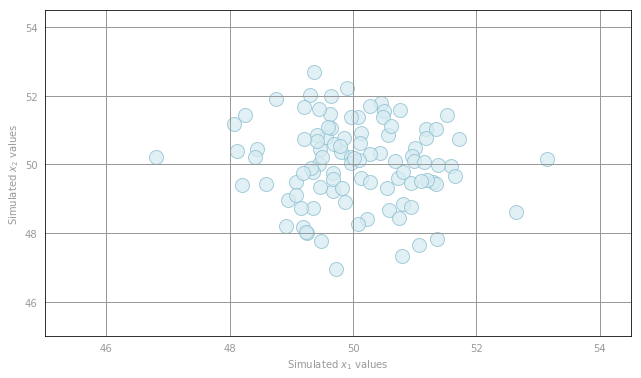

In [38]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
plt.show()

아래는 위와 같이 create_2D_gaussian 함수를 사용하여 임의의 데이터를 생성한 후 데이터를 시각화한 결과를 보여준다. 다만, 이번에는 공분산의 값을 0.9로 지정하여 서로 관련성 있는 데이터를 보여준다. 앞으로 계속 사용할 데이터는 아래 데이터가 될 것이다.

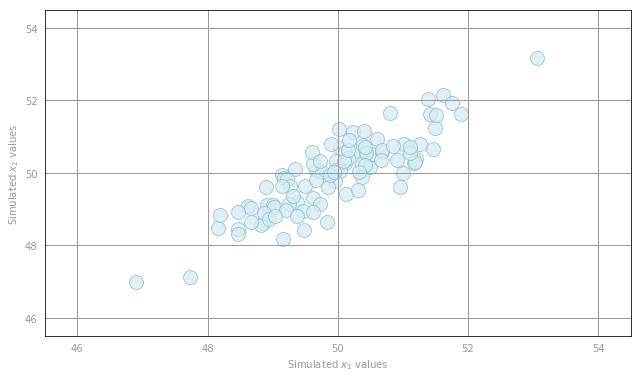

In [39]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.show()

## 2. PCA 구하기
이제 테스트할 데이터가 준비되었음으로 PCA를 구하는 과정을 차례대로 진행하겠다. PCA를 구하기 위한 가장 첫 번째 단계는 각 차원의 

#### 2.1 데이터 중심화

In [40]:
#correlated_data = sc.parallelize(data_correlated)

mean_correlated = np.mean(data_correlated, axis=0)
correlated_data_zero_mean = list(map(lambda x: x - mean_correlated, data_correlated))
print(mean_correlated)

[ 49.95739037  49.97180477]


#### 2.2 공분산 행렬 생성

In [41]:
from functools import reduce
correlated_cov = reduce(lambda a, b: a + b, map(lambda x: np.outer(x, x), correlated_data_zero_mean))
print(correlated_cov)
print(len(correlated_data_zero_mean))
correlated_cov = correlated_cov/len(correlated_data_zero_mean)
print(correlated_cov)

[[  99.55838626   90.1489893 ]
 [  90.1489893   108.60749731]]
100
[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


#### 2.3 Eigenvalue, Eigenvector 구하기

In [42]:
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlated_cov
eig_vals, eig_vecs = eigh (correlated_cov)
print('eigenvalues: {0}'.format(eig_vals))
print('\neigenvectors: \n{0}'.format(eig_vecs))

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
inds = np.argsort(eig_vals)
top_component = eig_vecs[:, inds[-1]]
print('\ntop principal component: {0}'.format(top_component))

eigenvalues: [ 0.13820481  1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [ 0.68915649  0.72461254]


#### 2.4 PCA 점수 구하기

In [97]:
correlated_data_scores = list(map(lambda x: np.dot(x, top_component), data_correlated))
correlated_data_scores[0:3]

[70.516828061106551, 69.306223556234471, 71.135881678263345]

## 3. PCA 함수 구현
이제 테스트할 데이터가 준비되었음으로 PCA를 구하는 과정을 차례대로 진행하겠다. PCA를 구하기 위한 가장 첫 번째 단계는 각 차원의 

#### 3.1 공분산 행렬 함수

In [44]:
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    cov = reduce(lambda a, b: a + b, map(lambda x: np.outer(x, x), correlated_data_zero_mean))
    cov = cov/len(correlated_data_zero_mean)

    return cov

correlated_cov_auto= estimate_covariance(data_correlated)
print(correlated_cov_auto)

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


#### 3.2  PCA 함수

In [45]:
def pca(data, k=2):
    cov = estimate_covariance(data)
    eig_vals, eig_vecs = eigh(cov)
    
    inds = np.argsort(eig_vals)[::-1]
    return eig_vecs[:, inds[:k]], map(lambda x: np.dot(x, eig_vecs[:, inds[:k]]), data), eig_vals[inds]
top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = pca(data_correlated)
print('top_components_correlated: \n{0}'.format(top_components_correlated))
print('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

top_components_correlated[:, 0]

top_components_correlated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

eigenvalues_correlated: 
[ 1.94345403  0.13820481]


array([ 0.68915649,  0.72461254])

## 4. PCA 적용

In [67]:
def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = np.mean(data_correlated, axis=0)[:2]
    demeaned = map(lambda v: v - means, data)
    projected = map(lambda v: (v.dot(top_component) /
                                        top_component.dot(top_component)) * top_component, demeaned)
    remeaned = map(lambda v: v + means, projected)
    x1,x2 = zip(*remeaned)

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(data_correlated, top_components_correlated, 5)

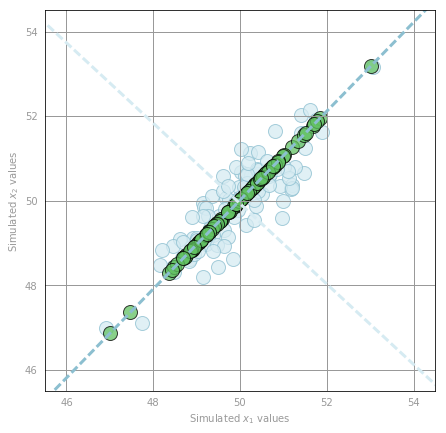

In [48]:
# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', edgecolors= '#000000', alpha=.75)
plt.show()


# Part2: sklearn을 이용한 PCA

explained variance ratio:[ 0.93360833  0.06639167]
first_pc:[ 0.68915649  0.72461254]
second_pc:[ 0.72461254 -0.68915649]
Covairance Matrix:[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


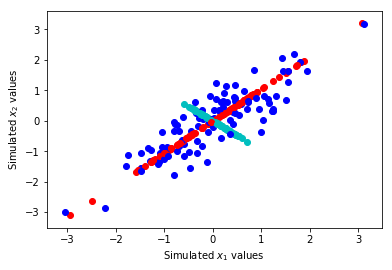

In [92]:
# PCA 함수 정의
def doPCA(data, n_components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components)
    pca.fit(data)
    return pca

# data_correlated에 PCA 적용
pca = doPCA(data_correlated, 2)

print("explained variance ratio:{0}".format(pca.explained_variance_ratio_))
first_pc = pca.components_[0]
second_pc = pca.components_[1]

print("first_pc:{0}".format(first_pc))
print("second_pc:{0}".format(second_pc))

# 기존 데이터에 PCA 적용
transformed_data = pca.transform(data_correlated)
print("Covairance Matrix:{0}".format(pca.get_covariance()))

# 기존 데이터 및 PC1과 PC2 적용한 결과 시각화
for ii, jj in zip(transformed_data, data_correlated-mean_correlated):
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color="r")
    plt.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1], color="c")
    plt.scatter(jj[0], jj[1], color="b")
    
plt.xlabel(r'Simulated $x_1$ values')
plt.ylabel(r'Simulated $x_2$ values')
plt.show()